In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import time
import cffi

In [ ]:
ffi = cffi.FFI()
ffi.cdef('float mixing(int n, int k, float *A, float *h, float *V, float eps, int max_iter);'
        'float mixing_plus(int n, int d, int k, float *A, float *h, float *Z, float eps, int max_iter);')

ffi.set_source('_part', r'''
        #include "part.h"
''', sources=['part.c'], source_extension='.c',
   extra_compile_args=['-O3'],
)

ffi.compile(verbose=True)
import _part

In [3]:
# Run mixing method
def mixing(A, h, V, max_iter=100, eps=0):
    n = A.shape[0]
    d = V.shape[1]
    assert A.shape[1] == n and h.shape[0] == n and h.shape[1] == d
    A = A.astype(np.float32)
    h = h.astype(np.float32)
    _V = V.astype(np.float32)

    diff = _part.lib.mixing(n, d, ffi.from_buffer('float[]', A), ffi.from_buffer('float[]', h), 
                            ffi.from_buffer('float[]', _V), eps, max_iter)
    V[:] = _V
    return diff

# Run the mixing_plus method
def mixing_plus(A, h, Z, k, max_iter=100, eps=0):
    n = A.shape[0]
    d = Z.shape[1]
    m = d // k
    assert A.shape[1] == n and h.shape[0] == n and h.shape[1] == d
    assert d % k == 0
    A = A.astype(np.float32)
    h = h.reshape((n,m,k)).transpose(0,2,1)
    h = np.ascontiguousarray(h, dtype=np.float32)
    _Z = np.ascontiguousarray(Z.reshape((n,m,k)).transpose(0,2,1)).astype(np.float32)

    diff = _part.lib.mixing_plus(n, d, k, ffi.from_buffer('float[]', A), ffi.from_buffer('float[]', h), ffi.from_buffer('float[]', _Z), eps, max_iter)
    Z[:] = _Z.reshape((n,k,m)).transpose(0,2,1).reshape((n,d))
    return diff

In [4]:
# Generate all (k)^n strings in support of MRF
def generate_strings(n, k):
    assert k >= 2 and k < 10
    if n == 1:
        return [str(i) for i in range(k)]
    ret = []
    all_smaller_strings = generate_strings(n-1, k)
    for i in range(k):
        ret.extend([str(i) + s for s in all_smaller_strings])
    return ret

# Convert vector to string
def get_string_from_vector(v):
    ret = ""
    for digit in v:
        assert digit >=0 and digit < 10
        ret += str(digit)
    return ret

# Sample n vectors uniformly on unit sphere
def sample_unit_sphere(n, d):
    ret = np.random.normal(0, 1, size=(n, d))
    ret = ret / np.linalg.norm(ret, axis=1, keepdims=True)
    return ret

# Get f = \sum_{ij}Aij\delta(i, j)/2 + \sum_i\sum_k b_ik\delta(i, k)
def get_f(A, h, s):
    k = h.shape[1]
    n = A.shape[0]
    if type(s) == str:
        s = np.array(list(s), dtype=int)
    delta = np.zeros((k, n))
    delta[s, np.arange(n)] = 1
    sm = np.sum((delta.T @ delta) * A) - np.sum(A) / 2
    truth = np.eye(k)
    sm += 2 * np.sum((delta.T @ truth) * h) - np.sum(h)
    return sm

In [5]:
# Multiply V by the matrix S efficiently
def mul_S(s, V):
    d = V.shape[1]
    k = s.shape[0]
    assert d % k == 0
    return (V.reshape(-1, d // k, k) @ s).reshape(V.shape)

# Rounding in the multi-class case
def obtain_rounded_v(V, B):
    n = V.shape[0]
    d = V.shape[1]
    k = B.shape[0]
    r = np.random.normal(0, 1, size=(k, d))
    r = r / np.linalg.norm(r, axis=1, keepdims=True)
    
    rounded_v = np.argmax(V @ r.T, axis=1)
    rounded_v_one_hot = np.zeros((n, k))
    rounded_v_one_hot[np.arange(n), rounded_v] = 1
    
    # shape(num_classes): saying that r:i maps to S:j
    r_to_B = np.argmax(r @ B.T, axis=1)
    transformation_matrix = np.zeros((k, k))
    transformation_matrix[np.arange(k), r_to_B] = 1
    rounded_v_one_hot = rounded_v_one_hot @ transformation_matrix
    rounded_v = np.argmax(rounded_v_one_hot, axis=1)
    
    return rounded_v

In [6]:
# Compute the log-sum-exp of a list safely
def LSE(y):
    max_y = np.max(y)
    return np.log(np.sum(np.exp(np.array(y)-max_y))) + max_y

# Routine to compute partition function: Algorithm 4 in paper
def compute_logZ_sdp(A, h, rounding_iters=10000, method="mixing"):
    n = len(A)
    k = h.shape[1]
    
    if method == "mixing-plus":
        d = int(np.ceil(k * np.sqrt(2*n) + 1))

        while(d % k != 0):
            d += 1
        assert d >= k

        C_hat = (k/(k-1))*np.eye(k) - (1/(k-1))*np.full((k, k), 1)
        U, Sigma, Ut = np.linalg.svd(C_hat)
        s = (np.diag(Sigma) ** 0.5) @ Ut

        Z = np.random.normal(0, 1, size=(n, d))
        Z = np.abs(Z)
        Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)

        B = np.zeros((k, d))
        B[np.arange(k), np.arange(k)] = 1

        _h = h @ B

        Z = np.asarray(Z, order='C')
        A = np.asarray(A, order='C')
        _h = np.asarray(_h, order='C') 

        diff = mixing_plus(A, _h, Z, k, max_iter=100, eps=0)

        V = mul_S(s.T, Z)
        B = mul_S(s.T, B)
    elif method == "mixing":
        d = int(np.ceil(np.sqrt(2*(n+k*(k+1)/2)) + 1))
        
        V = sample_unit_sphere(n, d)
        B = np.zeros((k, d))
        B[np.arange(k), np.arange(k)] = 1
        r0 = np.sum(B, axis=0) / k
        c = np.sqrt((k - 1) / k)
        B = (B - r0[np.newaxis, :]) / c
        _h = h @ B
        V = np.asarray(V, order='C')
        A = np.asarray(A, order='C')
        _h = np.asarray(_h, order='C')
        diff = mixing(A, _h, V)
    
    sdp_logZ = np.trace(A.T @ (V @ V.T)) / 2  + np.sum((V @ B.T) * h)
    
    s_list = {}
    f_list = []
    for _ in range(rounding_iters):
        x = obtain_rounded_v(V, B)
        f = get_f(A, h, x)
        s = get_string_from_vector(x)
        if s not in s_list:
            s_list[s] = 1
            f_list.append(f)

    rem = np.log(1-np.exp(np.log(len(f_list))-n*np.log(k)))

    y_list = []
    while True:
        if len(y_list) >= rounding_iters: break
        x = np.random.choice(k, n, replace=True)
        s = get_string_from_vector(x)
        if s in s_list: continue
        f = get_f(A, h, x)
        log_q = -n * np.log(k) - rem
        f_minus_log_q = f - log_q
        y_list.append(f_minus_log_q)
    sm = LSE(y_list) - np.log(len(y_list))
    sm = LSE([sm]+f_list)

    rounded_logZ = sm
    return sdp_logZ, rounded_logZ

In [8]:
# Load the data
coupling_data = np.load("../data/4_class_coupling_data.npy")
bias_data = np.load("../data/4_class_bias.npy")
logZ_data = np.load("../data/4_class_logZ.npy")
cw_len = coupling_data.shape[-2]
num_samples = coupling_data.shape[-1]
num_classes = bias_data.shape[1]
n = coupling_data.shape[0]
print(n, num_classes)

8 4


In [11]:
# Run our algorithm for all the problem instances
sdp, sdp_r = [], []
t_list = []
rounding_iters = 5000
for i in range(cw_len):
    diff_sdp, diff_sdp_r = [], []
    for sample in range(10):
        print("CW =", i, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, i, sample]
        h = bias_data[:, :, i, sample]
        ground_truth = logZ_data[i, sample]
        s = time.time()
        sdp_logZ, rounded_logZ = compute_logZ_sdp(A, h, rounding_iters=rounding_iters, method="mixing-plus")
        t_list.append(time.time() - s)
        diff_sdp.append(np.abs(ground_truth - sdp_logZ))
        diff_sdp_r.append(np.abs(ground_truth - rounded_logZ))
    sdp.append(np.mean(diff_sdp))
    sdp_r.append(np.mean(diff_sdp_r))

<h2> AIS

In [23]:
# p(x) \propto \exp(\sum_{ij}Aij\delta(i, j)/2 + \sum_i\sum_k b_ik\delta(i, k))
# x is a vector in [0, num_classes-1]^{n}
def gibbs_sampling(A, h, x, T, num_cycles=10):
    n = len(x)
    num_classes = h.shape[1]
    for cycle in range(num_cycles):
        for i in range(n):
            mx = -np.inf
            for j in range(num_classes):
                x[i] = j
                f_j = get_f(A, h, x) / T
                mx = max(mx, f_j)
                
            denominator = 0
            for j in range(num_classes):
                x[i] = j
                denominator += np.exp(get_f(A, h, x) / T - mx)

            sm_p = 0
            p = np.random.rand()
            for j in range(num_classes):
                x[i] = j
                p_j = np.exp(get_f(A, h, x) / T - mx) / denominator
                sm_p += p_j
                if p < sm_p:
                    break
    return x

# f_k as defined in appendix
def log_f_k(x, k, inv_temps, A, h):
    n = len(x)
    num_classes = h.shape[1]
    weight_on_uniform = (inv_temps[k] - 1) * n * np.log(num_classes)
    f = get_f(A, h, x)
    weight_on_true = inv_temps[k] * (f)
    return weight_on_uniform + weight_on_true

# AIS as described in pseudocode in appendix
def ais(A, h, num_samples=500, K=100, num_cycles=10):
    n = len(A)
    num_classes = h.shape[1]
    inv_temps = np.linspace(0, 1, K)
    sm = 0
    log_w_list = []
    mx = -np.inf
    for i in range(num_samples):  
        x = np.random.choice(num_classes, size=n, replace=True)
        w = 0
        for k in range(1, K):
            w = w + log_f_k(x, k, inv_temps, A, h) - log_f_k(x, k-1, inv_temps, A, h)
            x = gibbs_sampling(A, h, x, 1 / inv_temps[k], num_cycles=num_cycles)
        log_w_list.append(w)
        mx = max(mx, w)

    log_w_list = [elem - mx for elem in log_w_list]
    logZ = mx + np.log(np.sum(np.exp(log_w_list))) - np.log(num_samples)
    return logZ

In [24]:
# Set AIS parameters (K, num_cycles, num_samples_ais)
K = 3
num_cycles = 1
num_samples_ais = 500

# Run AIS on all problem instances
t_list = []
ais_error = []
for cw in range(cw_len):
    diff_ais = []
    for sample in range(num_samples):
        print("CW =", cw, " Sample number =", sample, end="\r")
        A = coupling_data[:, :, cw, sample]
        h = bias_data[:, :, cw, sample]
        ground_truth = logZ_data[cw, sample]
        s = time.time()
        ais_estimate = ais(A, h, num_samples=num_samples_ais, K=K, num_cycles=num_cycles)
        t_list.append(time.time() - s)
        diff_ais.append(np.abs(ground_truth - ais_estimate))
    ais_error.append(np.mean(diff_ais))

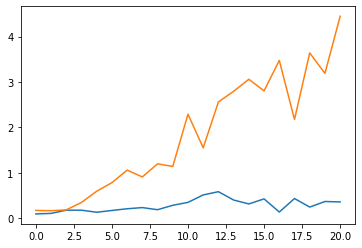

In [25]:
plt.plot(sdp_r)
plt.plot(ais_error)